In [1]:
import os
import datetime
import glob

import cv2
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
def write_hdf5(arr, outfile):
    with h5py.File(outfile, "w") as f:
        f.create_dataset("image", data=arr, dtype=arr.dtype)

def load_hdf5(infile):
    with h5py.File(infile, "r") as f:
        return f["image"][()]

def get_train_data(dataset_path):
    train_images = load_hdf5(dataset_path + '/hdf5/train_images.hdf5')
    train_masks = load_hdf5(dataset_path + '/hdf5/train_masks.hdf5')
    return train_images, train_masks

def get_validate_data(dataset_path):
    val_images = load_hdf5(dataset_path + '/hdf5/val_images.hdf5')
    val_masks = load_hdf5(dataset_path + '/hdf5/val_masks.hdf5')
    return val_images, val_masks

In [3]:
def adjust_gamma(image, gamma):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)])

    return cv2.LUT(image, table)

def clahe_equalized(image):

    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8)) 
    image = clahe.apply(image)

    return image

def preprocess(images, INPUT_SIZE):
    
    preprocessed_images = []
    
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = clahe_equalized(image)
        image = adjust_gamma(image, 1.1)
        image = image.astype(np.float32)
        image = image / 255.
        preprocessed_images.append(image)

    preprocessed_images = np.array(preprocessed_images)
    preprocessed_images = np.reshape(preprocessed_images, (len(preprocessed_images), INPUT_SIZE, INPUT_SIZE, 1))
    
    return preprocessed_images

In [4]:
train_images, train_masks = get_train_data(dataset_path='./DRIVE')
val_images, val_masks = get_validate_data(dataset_path='./DRIVE')

In [5]:
train_images = preprocess(images=train_images, INPUT_SIZE=512)
val_images = preprocess(images=val_images, INPUT_SIZE=512)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
------------------TRAIN------------------
No. of Images: 232 || Masks: 232
Shape of Images: (232, 512, 512, 1) || Masks: (232, 512, 512, 1)
Type of Images: float32 || Masks: float32
-----------------VALIDATE----------------
No. of Images: 4 || Masks: 4
Shape of Images: (4, 512, 512, 1) || Masks: (4, 512, 512, 1)
Type of Images: float32 || Masks: float32 

-------------------------------------Input Samples-------------------------------------


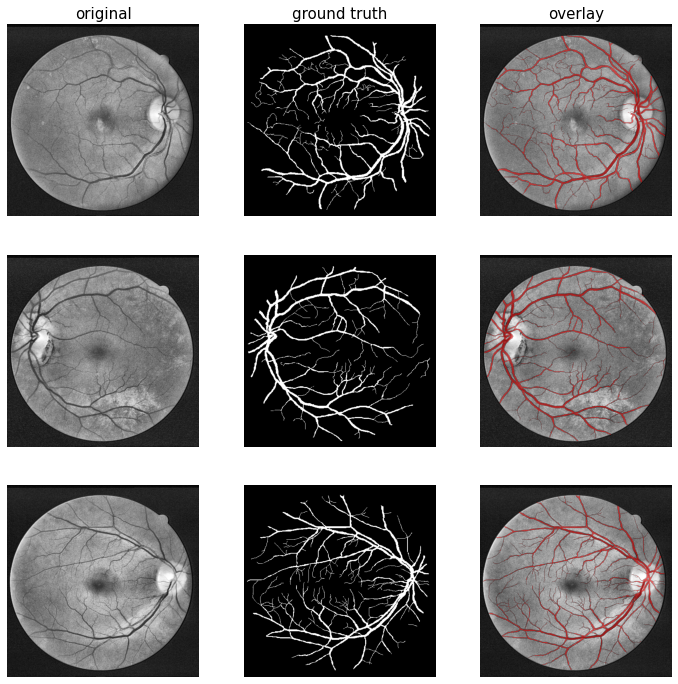

In [6]:
from keras_unet.utils import plot_imgs

print("------------------TRAIN------------------")
print(f"No. of Images: {len(train_images)} || Masks: {len(train_masks)}")
print(f"Shape of Images: {train_images.shape} || Masks: {train_masks.shape}")
print(f"Type of Images: {train_images.dtype} || Masks: {train_masks.dtype}") 

print("-----------------VALIDATE----------------")
print(f"No. of Images: {len(val_images)} || Masks: {len(val_masks)}")
print(f"Shape of Images: {val_images.shape} || Masks: {val_masks.shape}")
print(f"Type of Images: {val_images.dtype} || Masks: {val_masks.dtype} \n") 

print('-------------------------------------Input Samples-------------------------------------')
plot_imgs(org_imgs=train_images, mask_imgs=train_masks, pred_imgs=None, nm_img_to_plot=3, color="red")

In [7]:
def IOU(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import plot_model
from keras_unet.models import custom_unet

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INPUT_SIZE = 512
INPUT_CHANNEL = 1

def build_model(INPUT_SIZE, INPUT_CHANNEL, LR=1e-3):

    model = custom_unet(
        input_shape=(INPUT_SIZE, INPUT_SIZE, INPUT_CHANNEL),
        num_classes=1,
        use_batch_norm=True,
        upsample_mode="deconv",
        dropout=0.1,
        dropout_change_per_layer=0.0,
        dropout_type="spatial",
        use_dropout_on_upsampling=False,
        use_attention=True,
        filters=64,
        num_layers=3,
        output_activation='sigmoid')
    
    model.compile(optimizer=Adam(lr=LR), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', Recall(), Precision(), IOU])
    
    return model


with strategy.scope():
    model = build_model(INPUT_SIZE, INPUT_CHANNEL, LR)
    
model.summary()

plot_model(model, show_shapes = True, to_file = './DRIVE/checkpoint/UNET_SPATIAL_ATTENTION_model.png')

model_json = model.to_json()
open('./DRIVE/checkpoint/vessel_segmentation_architecture.json', 'w').write(model_json)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

31396

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau

# %load_ext tensorboard
%reload_ext tensorboard
log_dir = os.path.join("./DRIVE/checkpoint/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,
                                   write_images=True,
                                   write_graph=True,
                                   histogram_freq=1)

model_checkpoint = ModelCheckpoint(
    filepath='./DRIVE/checkpoint/UNET_DRIVE_BEST_WEIGHTS.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True)

early_stopper = EarlyStopping(monitor='val_loss',
                              patience=5,
                              verbose=0,
                              mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

In [11]:
from sklearn.model_selection import KFold

INPUT_SIZE = 512
INPUT_CHANNEL = 1
LR = 1e-3
EPOCHS = 20
BATCH = 2
NUM_FOLDS = 3

inputs = np.concatenate((train_images, val_images), axis=0)
targets = np.concatenate((train_masks, val_masks), axis=0)

acc_per_fold = []
loss_per_fold = []

init_weights = model.get_weights()

kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=None)
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    X_train, X_test = inputs[train], inputs[test]
    Y_train, Y_test = targets[train], targets[test]
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, Y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH,
                        validation_data=(X_test, Y_test),
                        verbose=1,
                        callbacks=[model_checkpoint, tensorboard_callback, early_stopper, reduce_lr])

    scores = model.evaluate(X_test, Y_test, verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no = fold_no + 1
    
    model.save_weights('./DRIVE/checkpoint/UNET_DRIVE_LAST_WEIGHTS.h5', overwrite=True)
    model.set_weights(init_weights)

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 68 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 68 all-reduces with algorithm = hierarchical_copy, num_packs = 1
79/79 [==============================] - 43s 325ms/step - loss: 0.4901 - accuracy: 0.8536 - recall: 0.7467 - precision: 0.3977 - IOU: 0.1889 - val_loss: 6.3489 - val_accuracy: 0.2550 - val_recall: 0.9790 - val_precision: 0.1035 - val_IOU: 0.1142

Epoch 00001: loss improved from inf to 0.36166, saving model to ./DRIVE/checkpoint\UNET_DRIVE_BEST_WEIGHTS.h5
Epoch 2/20
79/79 [==============================] - 21s 270ms/step - loss: 0.2015 - accuracy: 0.9550 - recall: 0.6497 - precision: 0.7968 - IOU: 0.3139 - val_loss: 0.2256 - val_accuracy: 0.9259 - val_recall: 0.1633 - val_precision: 0.9507 - val_IOU: 0.1700

Epoch 00002: loss improved from 0.36166 to 0.17992, saving model to ./DRIVE/che

79/79 [==============================] - 21s 269ms/step - loss: 0.0974 - accuracy: 0.9628 - recall: 0.7160 - precision: 0.8362 - IOU: 0.5195 - val_loss: 0.1091 - val_accuracy: 0.9592 - val_recall: 0.6967 - val_precision: 0.7975 - val_IOU: 0.4997

Epoch 00008: loss did not improve from 0.07285
Epoch 9/20
79/79 [==============================] - 21s 262ms/step - loss: 0.0951 - accuracy: 0.9635 - recall: 0.7225 - precision: 0.8387 - IOU: 0.5260 - val_loss: 0.1093 - val_accuracy: 0.9578 - val_recall: 0.7664 - val_precision: 0.7445 - val_IOU: 0.4944

Epoch 00009: loss did not improve from 0.07285
Epoch 10/20
79/79 [==============================] - 21s 267ms/step - loss: 0.0949 - accuracy: 0.9635 - recall: 0.7220 - precision: 0.8396 - IOU: 0.5274 - val_loss: 0.1059 - val_accuracy: 0.9606 - val_recall: 0.6508 - val_precision: 0.8509 - val_IOU: 0.5121

Epoch 00010: loss did not improve from 0.07285
Epoch 11/20
79/79 [==============================] - 20s 260ms/step - loss: 0.0934 - accuracy: 

In [11]:
EPOCHS = 40
BATCH = 4

history = model.fit(train_images, train_masks,
                    epochs=EPOCHS,
                    batch_size=BATCH,
                    validation_data=(val_images, val_masks),
                    verbose=1,
                    callbacks=[model_checkpoint, tensorboard_callback, early_stopper, reduce_lr])

model.save_weights('./DRIVE/checkpoint/UNET_DRIVE_NOKFOLD_LAST_WEIGHTS.h5', overwrite=True)

Epoch 1/40
58/58 [==============================] - 26s 450ms/step - loss: 0.2975 - accuracy: 0.9506 - recall: 0.6962 - precision: 0.7243 - IOU: 0.2481 - val_loss: 0.8869 - val_accuracy: 0.7682 - val_recall: 0.2897 - val_precision: 0.1293 - val_IOU: 0.0916

Epoch 00001: loss improved from inf to 0.29752, saving model to ./DRIVE/checkpoint\UNET_DRIVE_BEST_WEIGHTS.h5
Epoch 2/40
58/58 [==============================] - 23s 390ms/step - loss: 0.1746 - accuracy: 0.9588 - recall: 0.6791 - precision: 0.8159 - IOU: 0.3462 - val_loss: 0.5642 - val_accuracy: 0.7865 - val_recall: 0.8446 - val_precision: 0.2690 - val_IOU: 0.2213

Epoch 00002: loss improved from 0.29752 to 0.17459, saving model to ./DRIVE/checkpoint\UNET_DRIVE_BEST_WEIGHTS.h5
Epoch 3/40
58/58 [==============================] - 23s 391ms/step - loss: 0.1387 - accuracy: 0.9594 - recall: 0.6996 - precision: 0.8066 - IOU: 0.4056 - val_loss: 0.1451 - val_accuracy: 0.9517 - val_recall: 0.4937 - val_precision: 0.9120 - val_IOU: 0.3579

Ep

In [14]:
print(list(history.history))

['loss', 'accuracy', 'recall', 'precision', 'IOU', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision', 'val_IOU', 'lr']


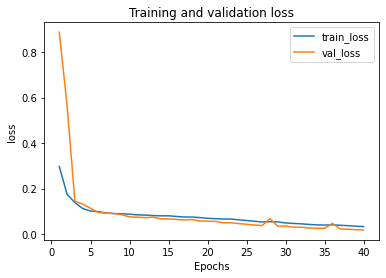

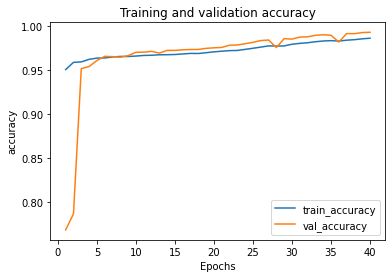

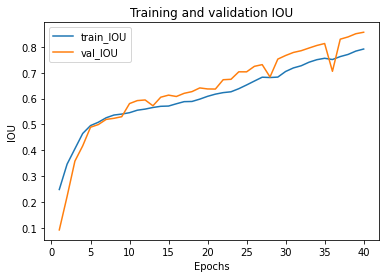

In [16]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]

    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.savefig("./DRIVE/checkpoint/" + metric + " " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), dpi = 300)
    plt.show()
    
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')
plot_metric(history, 'IOU')

In [ ]:
%tensorboard --logdir logs

In [34]:
def mkdir_if_not_exist(dir_name, is_delete=False):
    try:
        if is_delete:
            if os.path.exists(dir_name):
                shutil.rmtree(dir_name)
                print(u'[INFO] Directory "%s" exists, deleting.' % dir_name)

        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
            print(u'[INFO] Directory "%s" not exists, creating.' % dir_name)
        return True
    except Exception as e:
        print('[Exception] %s' % e)
        return False

def test_generator(test_path, target_size):
    files=sorted(os.listdir(test_path))
    num_image=len(files)
    for i in range(num_image):
        image = Image.open(os.path.join(test_path,files[i]))
        image = image.resize(target_size)
        image = np.array(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = clahe_equalized(image)
        image = adjust_gamma(image, 1.1)
        image = image.astype(np.float32)
        image = image / 255.
        img = np.reshape(image, (1,) + image.shape)
        yield img

def save_results(img_path, save_path, npyfile):
    files = os.listdir(img_path)
    mkdir_if_not_exist(save_path)
    for i, item in enumerate(npyfile):
        image = item * 255
        image = image.astype(np.uint8)
        cv2.imwrite(os.path.join(save_path, f'result{i}_predict.png'), image)

In [45]:
from tensorflow.keras.utils import CustomObjectScope

test_gen = test_generator(test_path='./DRIVE/test/images/', target_size=(512,512))
with CustomObjectScope({'IOU': IOU}):
    model = tf.keras.models.load_model('./DRIVE/checkpoint/UNET_DRIVE_BEST_WEIGHTS.h5')
results = model.predict(test_gen, verbose=1)

20/20 [==============================] - 1s 60ms/step


In [30]:
def normalize_color(image):

    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    return image

def read_images(paths, INPUT_SIZE):
    
    images = []
    
    for path in paths:
        img = Image.open(path)
        img = img.resize((INPUT_SIZE, INPUT_SIZE))
        img = np.array(img)
        img = normalize_color(img)
        images.append(img)
    
    return images

def read_masks(paths, INPUT_SIZE):
    
    masks = []
    
    for path in paths:
        mask = Image.open(path).convert("L")
        mask = mask.resize((INPUT_SIZE, INPUT_SIZE))
        mask = np.array(mask)
        mask = mask / 255.
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        mask = mask.astype(np.float32)
        masks.append(mask)
    
    return masks
    
def load_data(path, INPUT_SIZE):
    images = sorted(glob.glob(os.path.join(path, "images/*")))
    masks = sorted(glob.glob(os.path.join(path, "groundtruth/*")))
    
    x = read_images(images, INPUT_SIZE)
    y = read_masks(masks, INPUT_SIZE)

    x = np.array(x)
    y = np.array(y)

    x = np.reshape(x, (len(x), INPUT_SIZE, INPUT_SIZE, 3))
    y = np.reshape(y, (len(y), INPUT_SIZE, INPUT_SIZE, 1))
    
    return (x, y)

In [31]:
test_images, test_masks = load_data(path='./DRIVE/test/', INPUT_SIZE=512)

-------------------------------------------Test Results-------------------------------------------


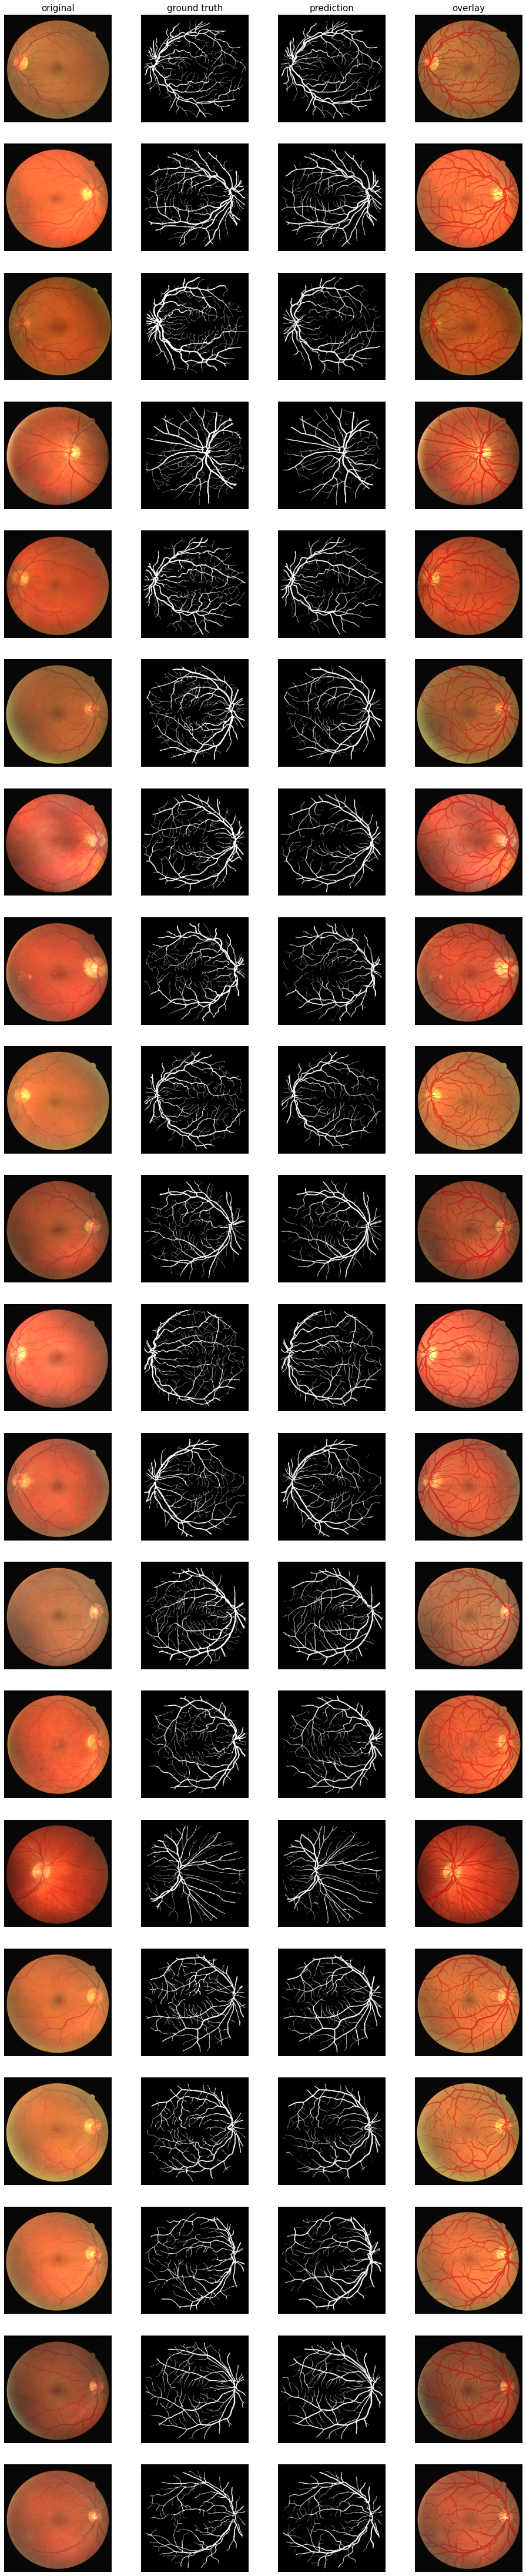

In [32]:
from keras_unet.utils import plot_imgs

print('-------------------------------------------Test Results-------------------------------------------')
plot_imgs(org_imgs=test_images, mask_imgs=test_masks, pred_imgs=results, nm_img_to_plot=len(results), color="red")

In [35]:
save_results('./DRIVE/test/images/','./DRIVE/test/segment_results/', results)

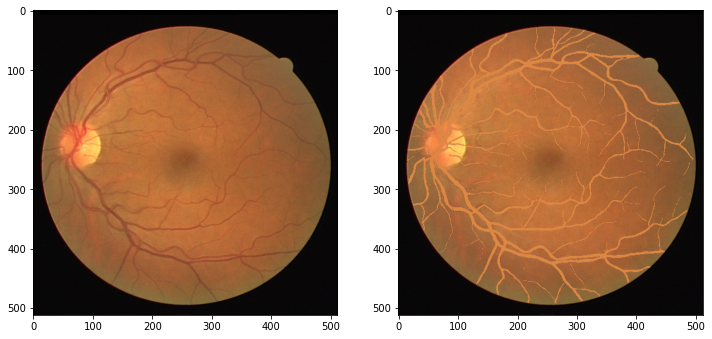

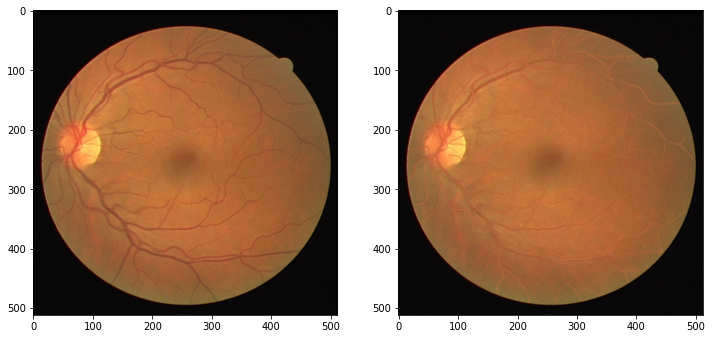

In [89]:
retina = test_images[0]
retina = cv2.cvtColor(retina, cv2.COLOR_BGR2RGB)
mask = results[0]
mask = mask * 255
mask = mask.astype(np.uint8)
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

_, mask = cv2.threshold(mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)

green_vessels = np.copy(retina)
green_vessels[(mask==255).all(-1)] = [66,136,220]

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(cv2.cvtColor(retina, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(green_vessels, cv2.COLOR_BGR2RGB))

green_vessels_w = cv2.addWeighted(green_vessels, 0.3, retina, 0.7, 0, green_vessels)

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(cv2.cvtColor(retina, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(green_vessels_w, cv2.COLOR_BGR2RGB))